In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

# Random Forest

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 43.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Importing geojson points

In [ ]:
# Paths to manually split datasets
#geojson_path = '/content/drive/MyDrive/classification/Training_test_validation2/Au_Cu_Zn_Pb_alterations.geojson'
geojson_path = '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Au_Cu_Zn_Pb_alterations_filtered_rockchip_samples.geojson'



#  # Check if there are any NaN values in the GeoDataFrame
# if geo_data.isnull().any().any():
#     print("The dataset contains NaN values. Dropping rows with NaN values.")
#     # Drop rows with NaN values
#     geo_data = geo_data.dropna()

# else:
#     print("The dataset does not contain any NaN values.")


geo_data = gpd.read_file(geojson_path)
geo_data.tail()
#geo_data.plot()

# Export to shapefile or
#output_shapefile = '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Au_Cu_Zn_Pb_alterations_filtered_rockchip_samples.csv'
#geo_data.to_csv(output_shapefile, index=False)


,fid,Easting,Northing,Elv,Au_ppb,Cu_ppm,Pb_ppm,Zn_ppm,Phyllic_PCA1_proj,Iron-oxide_PCA1_proj,Argillic_PCA1_Proj,Propylitic_PCA1_proj,classvalue,classvalue1,geometry
1784,1785,411800.0,1922050.0,NaN,20.0,7,0,7,2.50653,2.61583,1.87282,2.84143,1,1,POINT (411800 1922050)
1785,1786,411100.0,1922150.0,NaN,2.0,107,1,1,2.50713,2.56293,1.89111,2.88079,1,2,POINT (411100 1922150)
1786,1787,410482.0,1921200.0,NaN,3.0,106,2,6,2.40434,2.26102,1.69949,2.98753,1,2,POINT (410482 1921200)
1787,1788,392589.0,1855421.0,NaN,10.0,92,5,106,2.55142,2.18003,1.78838,2.97261,1,1,POINT (392589 1855421)
1788,1789,392478.0,1855452.0,NaN,25.0,7,5,19,2.54400,2.34448,1.79940,2.82601,1,1,POINT (392478 1855452)


In [ ]:
# Relevant columns
relevant_columns = [
    'Argillic_PCA1_Proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj',
    'Iron-oxide_PCA1_proj',
    'classvalue'  # Target column
]

# Select relevant columns
selected_data = geo_data[relevant_columns]

# Display the selected data
print(selected_data.head())

   Argillic_PCA1_Proj  Phyllic_PCA1_proj  Propylitic_PCA1_proj  \
0             1.63973            2.40117               2.92081   
1             1.66190            2.36735               3.08944   
2             1.64166            2.36837               3.17673   
3             1.69066            2.47477               2.90041   
4             1.77048            2.50653               2.84143   

   Iron-oxide_PCA1_proj  classvalue  
0               2.18944           0  
1               2.30059           0  
2               2.03928           0  
3               2.22484           0  
4               2.24257           0  


# Original, oversampling and undersampling data

In [1]:
# Spliting data
# Separate features and target from the original dataset
X = selected_data.drop('classvalue', axis=1)  # Features
y = selected_data['classvalue']  # Target

# Step 1: Split the data into training (70%), test (15%), validation (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# 1. Original Data
# Check class distribution of the original data
print ("######Original Data###########")
print("Before:", y_train.value_counts())
print("After:", y_train.value_counts())

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print ("########Oversampling###########")
print("Before:", y_train.value_counts())
print("After Oversampling:", y_train_smote.value_counts())


# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
# Check class distribution after undersampling
print ("#######under sampling###########")
print("Before:", y_train.value_counts())
print("After undersampling:", y_train_under.value_counts())


NameError: name 'selected_data' is not defined

In [ ]:
# Step 2: Convert validation set into a DataFrame
# Combine features (X_val) and labels (y_val) into a single DataFrame
#validation_data = pd.DataFrame(X_val)
#validation_data['label'] = y_val.values  # Add the target column to the DataFrame

# Step 3: Export the DataFrame to a CSV file
#validation_data.to_csv('/content/drive/MyDrive/classification/Training_test_validation2/Trial2/validation_dataaa.csv', index=False)

# Original test, Oversampled test and under sampled test

In [ ]:
# # 1. Original Data
# # Check class distribution of the original test
# print ("######Original Test Data###########")
# print("Before:", y_test.value_counts())
# print("After:", y_test.value_counts())

# # 2. Oversampling using SMOTE
# smote = SMOTE(random_state=42)
# X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

# # Check class distribution after oversampling
# print ("########Oversampling Test ###########")
# print("Before:", y_test.value_counts())
# print("After Oversampling:", y_test_smote.value_counts())


# # 3. Undersampling using RandomUnderSampler
# undersampler = RandomUnderSampler(random_state=42)
# X_test_under, y_test_under = undersampler.fit_resample(X_test, y_test)
# # Check class distribution after undersampling
# print ("#######under sampling Test###########")
# print("Before:", y_test.value_counts())
# print("After undersampling:", y_test_under.value_counts())
# ###############################################################################
# # 1. Original Data
# # Check class distribution of the original test
# print ("######Original val Data###########")
# print("Before:", y_val.value_counts())
# print("After:", y_val.value_counts())

# # 2. Oversampling using SMOTE
# smote = SMOTE(random_state=42)
# X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

# # Check class distribution after oversampling
# print ("########Oversampling val ###########")
# print("Before:", y_val.value_counts())
# print("After Oversampling:", y_val_smote.value_counts())


# # 3. Undersampling using RandomUnderSampler
# undersampler = RandomUnderSampler(random_state=42)
# X_val_under, y_val_under = undersampler.fit_resample(X_val, y_val)
# # Check class distribution after undersampling
# print ("#######under sampling val###########")
# print("Before:", y_val.value_counts())
# print("After undersampling:", y_val_under.value_counts())


# Training the 3 models

In [ ]:
# Training the model
#1. Original data
model_original = RandomForestClassifier(random_state=42)
#model_original = RandomForestClassifier(random_state=42)
model_original.fit(X_train, y_train)
# Save the model
joblib.dump(model_original, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_original.pkl')

# 2. Oversampling using SMOTE
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
# Save the model
joblib.dump(model_smote, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_smote.pkl')

# 3. Undersampling using RandomUnderSampler
model_under = RandomForestClassifier(random_state=42)
model_under.fit(X_train_under, y_train_under)

# Save the model
joblib.dump(model_under, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_undersampling.pkl')

['/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_undersampling.pkl']

# Feature Importance

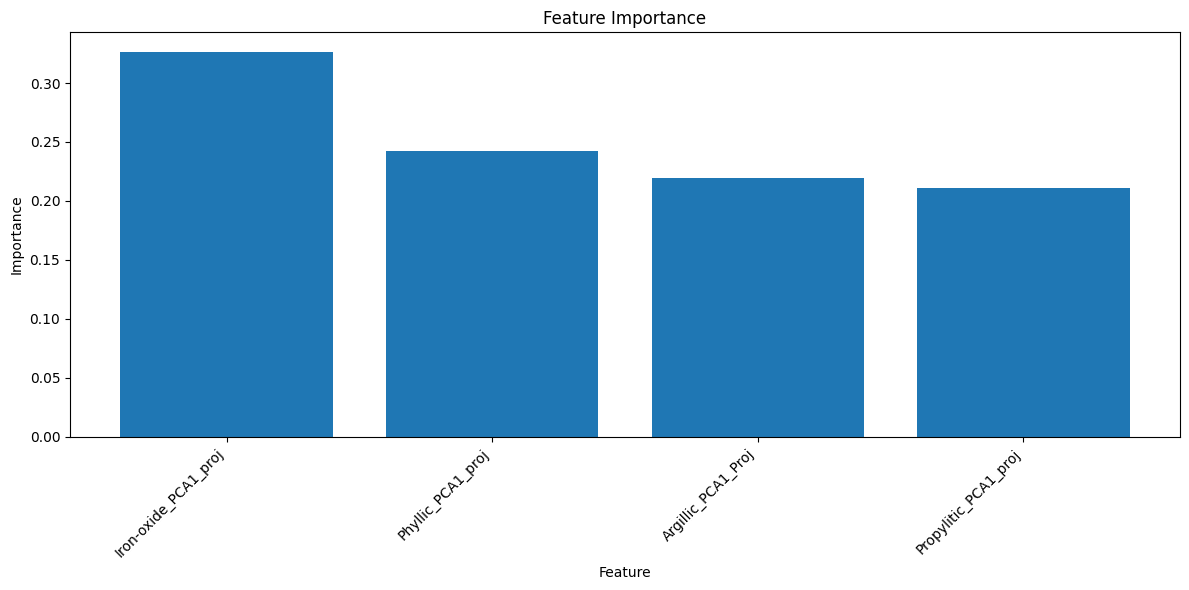

In [ ]:
# Assuming you have feature names
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Extract feature importance
feature_importances = model_original.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the DataFrame
#print(importance_df)

# Plot feature importance (vertical bar chart)
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Evaluation the models on test and validation data

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models and their datasets
models = {
    "Original Data": (model_original, X_train, X_test, y_train, y_test),
    "SMOTE Oversampling": (model_smote, X_train_smote, X_test, y_train_smote, y_test),
    "Random Undersampling": (model_under, X_train_under, X_test, y_train_under, y_test)
}




######################################################################################################################################
print("Original train data evaluation")
y_train_pred = model_original.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy: {train_accuracy:.2f}')
train_report = classification_report(y_train, y_train_pred)
print('\nClassification Report')
print(train_report)
train_cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(train_cm)
print("\n" + "#" * 50 + "\n")

print("Oversampled train data evaluation")
y_smote_train_pred = model_smote.predict(X_train_smote)
train_somte_accuracy = accuracy_score(y_train_smote, y_smote_train_pred)
print(f'Accuracy: {train_somte_accuracy:.2f}')
train_smote_report = classification_report(y_train_smote, y_smote_train_pred)
print('\nClassification Report')
print(train_smote_report)
train_smote_cm = confusion_matrix(y_train_smote, y_smote_train_pred)
print("Confusion Matrix:")
print(train_smote_cm)
print("\n" + "#" * 50 + "\n")

print("Undersampled train data evaluation")
y_train_under_pred = model_under.predict(X_train_under)
train_under_accuracy = accuracy_score(y_train_under, y_train_under_pred)
print(f'Accuracy: {train_under_accuracy:.2f}')
train_under_report = classification_report(y_train_under, y_train_under_pred)
print('\nClassification Report')
print(train_under_report)
train_under_cm = confusion_matrix(y_train_under, y_train_under_pred)
print("Confusion Matrix:")
print(train_under_cm)
print("\n" + "#" * 50 + "\n")
######################################################################################################################################
print("Original test data evaluation")
y_test_pred = model_original.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {test_accuracy:.2f}')
test_report = classification_report(y_test, y_test_pred)
print('\nClassification Report')
print(test_report)
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(test_cm)
print("\n" + "#" * 50 + "\n")

print("Oversampled test data evaluation")
y_smote_test_pred = model_smote.predict(X_test)
test_somte_accuracy = accuracy_score(y_test, y_smote_test_pred)
print(f'Accuracy: {test_somte_accuracy:.2f}')
test_smote_report = classification_report(y_test, y_smote_test_pred)
print('\nClassification Report')
print(test_smote_report)
test_smote_cm = confusion_matrix(y_test, y_smote_test_pred)
print("Confusion Matrix:")
print(test_smote_cm)
print("\n" + "#" * 50 + "\n")


print("Undersampled test data evaluation")
y_test_under_pred = model_under.predict(X_test)
test_under_accuracy = accuracy_score(y_test, y_test_under_pred)
print(f'Accuracy: {test_under_accuracy:.2f}')
test_under_report = classification_report(y_test, y_test_under_pred)
print('\nClassification Report')
print(test_under_report)
test_under_cm = confusion_matrix(y_test, y_test_under_pred)
print("Confusion Matrix:")
print(test_under_cm)
print("\n" + "#" * 50 + "\n")
######################################################################################################################################
print("Original val data evaluation")
y_val_pred = model_original.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {val_accuracy:.2f}')
val_report = classification_report(y_val, y_val_pred)
print('\nClassification Report')
print(val_report)
val_cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(val_cm)
print("\n" + "#" * 50 + "\n")


print("Oversampled val data evaluation")
y_smote_val_pred = model_smote.predict(X_val)
val_somte_accuracy = accuracy_score(y_val, y_smote_val_pred)
print(f'Accuracy: {val_somte_accuracy:.2f}')
val_smote_report = classification_report(y_val, y_smote_val_pred)
print('\nClassification Report')
print(val_smote_report)
val_smote_cm = confusion_matrix(y_val, y_smote_val_pred)
print("Confusion Matrix:")
print(val_smote_cm)
print("\n" + "#" * 50 + "\n")


print("Undersampled val data evaluation")
y_val_under_pred = model_under.predict(X_val)
val_under_accuracy = accuracy_score(y_val, y_val_under_pred)
print(f'Accuracy: {val_under_accuracy:.2f}')
val_under_report = classification_report(y_val, y_val_under_pred)
print('\nClassification Report')
print(val_under_report)
val_under_cm = confusion_matrix(y_val, y_val_under_pred)
print("Confusion Matrix:")
print(val_under_cm)
print("\n" + "#" * 50 + "\n")



Original train data evaluation
Accuracy: 1.00

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1194
           1       1.00      1.00      1.00       237

    accuracy                           1.00      1431
   macro avg       1.00      1.00      1.00      1431
weighted avg       1.00      1.00      1.00      1431

Confusion Matrix:
[[1194    0]
 [   0  237]]

##################################################

Oversampled train data evaluation
Accuracy: 1.00

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1194
           1       1.00      1.00      1.00      1194

    accuracy                           1.00      2388
   macro avg       1.00      1.00      1.00      2388
weighted avg       1.00      1.00      1.00      2388

Confusion Matrix:
[[1194    0]
 [   0 1194]]

##################################################

Undersamp

# Display the evaluation matrix

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize an empty list to store results
results_summary = []

# Dictionary of models to evaluate
models = {
    "Original Data": model_original,
    "SMOTE Oversampling": model_smote,
    "Random Undersampling": model_under
}

# Iterate through models
for model_name, model in models.items():
    # Evaluation on test data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

    # Store test results
    results_summary.append({
        "Dataset": "Test Data",
        "Model": model_name,
        "Accuracy": test_accuracy,
        "Precision": test_classification_report["weighted avg"]["precision"],
        "Recall": test_classification_report["weighted avg"]["recall"],
        "F1-Score": test_classification_report["weighted avg"]["f1-score"],
        "Confusion Matrix": test_confusion_matrix
    })

    # Evaluation on validation data
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_classification_report = classification_report(y_val, y_val_pred, output_dict=True)
    val_confusion_matrix = confusion_matrix(y_val, y_val_pred)

    # Store validation results
    results_summary.append({
        "Dataset": "Validation Data",
        "Model": model_name,
        "Accuracy": val_accuracy,
        "Precision": val_classification_report["weighted avg"]["precision"],
        "Recall": val_classification_report["weighted avg"]["recall"],
        "F1-Score": val_classification_report["weighted avg"]["f1-score"],
        "Confusion Matrix": val_confusion_matrix
    })

# Create a summary table
summary_table = pd.DataFrame(results_summary)

# Display the results as a table
print(summary_table)

print("Models evaluated, and results summarized.")


           Dataset                 Model  Accuracy  Precision    Recall  \
0        Test Data         Original Data  0.927374   0.928749  0.927374   
1  Validation Data         Original Data  0.899441   0.896644  0.899441   
2        Test Data    SMOTE Oversampling  0.843575   0.861576  0.843575   
3  Validation Data    SMOTE Oversampling  0.865922   0.869777  0.865922   
4        Test Data  Random Undersampling  0.765363   0.844104  0.765363   
5  Validation Data  Random Undersampling  0.776536   0.830203  0.776536   

   F1-Score       Confusion Matrix  
0  0.920515   [[148, 1], [12, 18]]  
1  0.885685   [[148, 2], [16, 13]]  
2  0.850619  [[131, 18], [10, 20]]  
3  0.867706  [[137, 13], [11, 18]]  
4  0.789617   [[115, 34], [8, 22]]  
5  0.795867  [[121, 29], [11, 18]]  
Models evaluated, and results summarized.


# Predicting the map

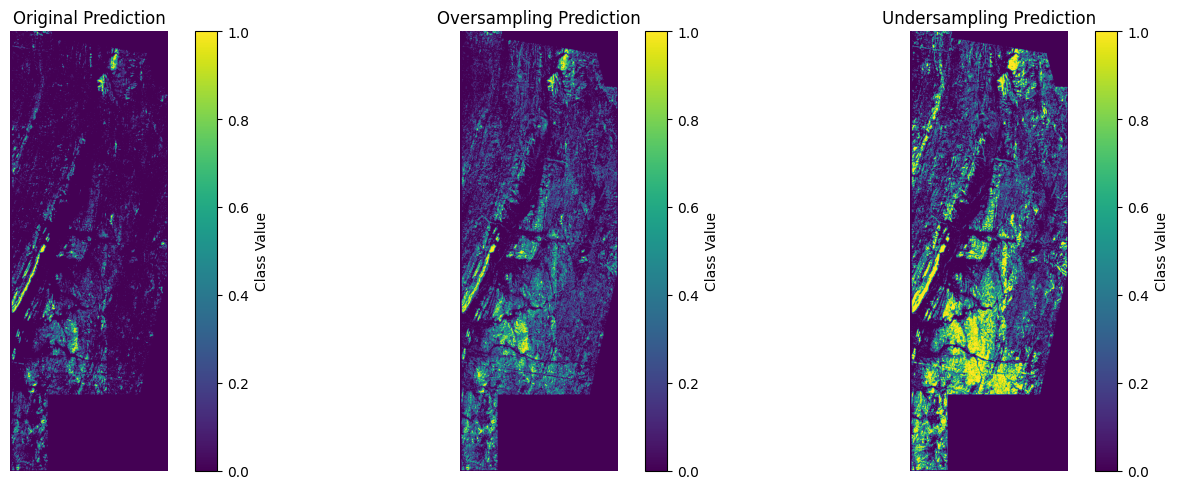

In [ ]:
from rasterio.enums import Resampling
import numpy as np

# Function to resample raster to match the reference raster
def resample_raster(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_meta = ref.meta
        ref_transform = ref.transform
        ref_shape = (ref.height, ref.width)

    with rasterio.open(source_path) as src:
        data = src.read(
            1,
            out_shape=ref_shape,
            resampling=Resampling.bilinear
        )
        transform = src.transform

    return data, ref_meta

# File paths for the input rasters
raster_files = [
    '/content/drive/MyDrive/classification/sample_data/Argillic_PCA1_Proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Iron-oxide_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Phyllic_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Propylitic_PCA1_proj.tif'
]

# Reference raster for resampling (use the first raster as a reference)
reference_raster = raster_files[0]

# Resample rasters
resampled_rasters = []
meta = None

for file in raster_files:
    resampled_data, meta = resample_raster(file, reference_raster)
    resampled_rasters.append(resampled_data)

# Stack the resampled rasters to form a feature array
stacked_data = np.stack(resampled_rasters, axis=-1)

# Flatten the data to create input features for the model
rows, cols, bands = stacked_data.shape
input_features = stacked_data.reshape(-1, bands)

# Match the feature names to those used during training
columns = [
    'Argillic_PCA1_Proj',
    'Iron-oxide_PCA1_proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj'
]
input_features_df = pd.DataFrame(input_features, columns=columns)

# Load the trained models
models = {
    "Original": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_original.pkl',
    "Oversampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_smote.pkl',
    "Undersampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/random_forest_undersampling.pkl'
}

# Plot results for each model
plt.figure(figsize=(15, 5))

for i, (model_name, model_path) in enumerate(models.items()):
    # Load the model
    model = joblib.load(model_path)


    # Get the expected feature order and reorder input features
    expected_feature_order = model.feature_names_in_
    input_features_df = input_features_df[expected_feature_order]

    # Predict the class values
    predicted_class = model.predict(input_features_df)

    # Reshape predictions back to the raster shape
    predicted_raster = predicted_class.reshape(rows, cols)

    # Save the prediction result as a new raster file
    output_file = f'/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Predicted_map/RF/predicted_class_RF_map_{model_name.lower().replace(" ", "_")}_train_test_val.tif'
    meta.update(
        dtype=rasterio.uint8,  # Ensure correct data type
        count=1,              # Number of bands
        nodata=255            # Set nodata to a valid value for uint8
    )

    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(predicted_raster.astype(rasterio.uint8), 1)

    # Plot the prediction raster
    plt.subplot(1, 3, i + 1)
    plt.imshow(predicted_raster, cmap='viridis')
    plt.title(f'{model_name} Prediction')
    plt.axis('off')
    plt.colorbar(label='Class Value')

plt.tight_layout()
plt.show()


# K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

#Apply K-fold cross validation
# 1. On original Data
accuracies_original = cross_val_score(estimator = model_original, X = X_train, y = y_train, cv = 10)
print (accuracies_original)
print(f"The mean accuracy is: {accuracies_original.mean()}")
print(f"The std accuracy is: {accuracies_original.std()}")
print("\n" + "#" * 50 + "\n")
# 2. On Oversampled Data
accuracies_smote = cross_val_score(estimator = model_smote, X = X_train_smote, y = y_train_smote, cv = 10)
print (accuracies_smote)
print(f"The mean accuracy of smote is: {accuracies_smote.mean()}")
print(f"The std accuracy of smote is: {accuracies_smote.std()}")
print("\n" + "#" * 50 + "\n")
# 3. On Undersampled Data
accuracies_under = cross_val_score(estimator = model_under, X = X_train_under, y = y_train_under, cv = 10)
print (accuracies_under)
print(f"The mean accuracy of under is: {accuracies_under.mean()}")
print(f"The std accuracy of under is: {accuracies_under.std()}")

[0.93055556 0.88811189 0.91608392 0.90909091 0.87412587 0.92307692
 0.9020979  0.92307692 0.92307692 0.9020979 ]
The mean accuracy is: 0.9091394716394715
The std accuracy is: 0.016902404142751477

##################################################

[0.93723849 0.90376569 0.92468619 0.92887029 0.94560669 0.91631799
 0.9539749  0.9539749  0.95378151 0.95378151]
The mean accuracy of smote is: 0.9371998171653599
The std accuracy of smote is: 0.01721409910396134

##################################################

[0.85416667 0.72916667 0.8125     0.77083333 0.74468085 0.89361702
 0.68085106 0.78723404 0.82978723 0.87234043]
The mean accuracy of under is: 0.7975177304964538
The std accuracy of under is: 0.06418794806211464


# Grid Search

In [ ]:
#Applying Grid search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters_original = [
    {'max_depth': [3,5,10,15,20],
     'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 400, 500],
    'min_samples_leaf': [2, 3, 4, 5],
    #'max_features': ['sqrt', 'log2', None],
    #'bootstrap': [True, False]
     }
]
grid_search_original = GridSearchCV(estimator = model_original,
                           param_grid = parameters_original,
                           scoring = 'recall',
                           cv = 10,
                           n_jobs = -1)
grid_search_original.fit(X_train, y_train)
best_accuracy_original = grid_search_original.best_score_
best_parameters_original = grid_search_original.best_params_

In [ ]:
best_parameters_original


{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'n_estimators': 100}

# SVM

# Importing Geojson points

In [ ]:
# Paths to geojson
#geojson_path = '/content/drive/MyDrive/classification/Training_test_validation2/Au_Cu_Zn_Pb_alterations.geojson'
geojson_path = '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Au_Cu_Zn_Pb_alterations_filtered_rockchip_samples.geojson'



geo_data = gpd.read_file(geojson_path)
geo_data.head()
#geo_data.plot()

# Export to shapefile
# output_shapefile = '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Au_Cu_Zn_Pb_alterations_filtered_rockchip_samples.shp'
# geo_data.to_file(output_shapefile, driver="ESRI Shapefile")


,fid,Easting,Northing,Elv,Au_ppb,Cu_ppm,Pb_ppm,Zn_ppm,Phyllic_PCA1_proj,Iron-oxide_PCA1_proj,Argillic_PCA1_Proj,Propylitic_PCA1_proj,classvalue,classvalue1,geometry
0,1,410736.0,1921892.0,NaN,2.0,25,4,58,2.40117,2.18944,1.63973,2.92081,0,0,POINT (410736 1921892)
1,2,410213.0,1921764.0,NaN,2.0,20,3,54,2.36735,2.30059,1.66190,3.08944,0,0,POINT (410213 1921764)
2,3,410011.0,1921640.0,NaN,2.0,17,4,82,2.36837,2.03928,1.64166,3.17673,0,0,POINT (410011 1921640)
3,4,410450.0,1921097.0,NaN,4.0,19,4,52,2.47477,2.22484,1.69066,2.90041,0,0,POINT (410450 1921097)
4,5,411269.0,1921818.0,NaN,2.0,39,4,49,2.50653,2.24257,1.77048,2.84143,0,0,POINT (411269 1921818)


In [ ]:
# Relevant columns
relevant_columns = [
    'Argillic_PCA1_Proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj',
    'Iron-oxide_PCA1_proj',
    'classvalue'  # Target column
]

# Select relevant columns
selected_data = geo_data[relevant_columns]

# Display the selected data
print(selected_data.head())

   Argillic_PCA1_Proj  Phyllic_PCA1_proj  Propylitic_PCA1_proj  \
0             1.63973            2.40117               2.92081   
1             1.66190            2.36735               3.08944   
2             1.64166            2.36837               3.17673   
3             1.69066            2.47477               2.90041   
4             1.77048            2.50653               2.84143   

   Iron-oxide_PCA1_proj  classvalue  
0               2.18944           0  
1               2.30059           0  
2               2.03928           0  
3               2.22484           0  
4               2.24257           0  


In [ ]:
# Spliting data
# Separate features and target from the original dataset
X = selected_data.drop('classvalue', axis=1)  # Features
y = selected_data['classvalue']  # Target

# Step 1: Split the data into training (70%), test (15%), validation (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Step 1: Split the data into training (70%) and test (30%)
#X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)


# 1. Original Data
# Check class distribution of the original data
print ("######Original Data###########")
print("Before:", y_train.value_counts())
print("After:", y_train.value_counts())

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print ("########Oversampling###########")
print("Before:", y_train.value_counts())
print("After Oversampling:", y_train_smote.value_counts())


# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
# Check class distribution after undersampling
print ("#######under sampling###########")
print("Before:", y_train.value_counts())
print("After undersampling:", y_train_under.value_counts())


######Original Data###########
Before: classvalue
0    1194
1     237
Name: count, dtype: int64
After: classvalue
0    1194
1     237
Name: count, dtype: int64
########Oversampling###########
Before: classvalue
0    1194
1     237
Name: count, dtype: int64
After Oversampling: classvalue
0    1194
1    1194
Name: count, dtype: int64
#######under sampling###########
Before: classvalue
0    1194
1     237
Name: count, dtype: int64
After undersampling: classvalue
0    237
1    237
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

# Training the models

In [ ]:
# 1. Original data
model_original = SVC(random_state=42)
model_original.fit(X_train, y_train)
# Save the model
joblib.dump(model_original, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_original.pkl')

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote = SVC(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
# Save the model
joblib.dump(model_smote, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_smote.pkl')

# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
model_under = SVC(random_state=42)
model_under.fit(X_train_under, y_train_under)

# Save the model
joblib.dump(model_under, '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_undersampling.pkl')

print("Models trained and saved with SVM classifier.")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

Models trained and saved with SVM classifier.


In [ ]:
# 1. Original Data
# Check class distribution of the original test
print ("######Original Test Data###########")
print("Before:", y_test.value_counts())
print("After:", y_test.value_counts())

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

# Check class distribution after oversampling
print ("########Oversampling Test ###########")
print("Before:", y_test.value_counts())
print("After Oversampling:", y_test_smote.value_counts())


# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_test_under, y_test_under = undersampler.fit_resample(X_test, y_test)
# Check class distribution after undersampling
print ("#######under sampling Test###########")
print("Before:", y_test.value_counts())
print("After undersampling:", y_test_under.value_counts())
###############################################################################
# 1. Original Data
# Check class distribution of the original test
print ("######Original val Data###########")
print("Before:", y_val.value_counts())
print("After:", y_val.value_counts())

# 2. Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

# Check class distribution after oversampling
print ("########Oversampling val ###########")
print("Before:", y_val.value_counts())
print("After Oversampling:", y_val_smote.value_counts())


# 3. Undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_val_under, y_val_under = undersampler.fit_resample(X_val, y_val)
# Check class distribution after undersampling
print ("#######under sampling val###########")
print("Before:", y_val.value_counts())
print("After undersampling:", y_val_under.value_counts())


######Original Test Data###########
Before: classvalue
0    149
1     30
Name: count, dtype: int64
After: classvalue
0    149
1     30
Name: count, dtype: int64
########Oversampling Test ###########
Before: classvalue
0    149
1     30
Name: count, dtype: int64
After Oversampling: classvalue
0    149
1    149
Name: count, dtype: int64
#######under sampling Test###########
Before: classvalue
0    149
1     30
Name: count, dtype: int64
After undersampling: classvalue
0    30
1    30
Name: count, dtype: int64
######Original val Data###########
Before: classvalue
0    150
1     29
Name: count, dtype: int64
After: classvalue
0    150
1     29
Name: count, dtype: int64
########Oversampling val ###########
Before: classvalue
0    150
1     29
Name: count, dtype: int64
After Oversampling: classvalue
0    150
1    150
Name: count, dtype: int64
#######under sampling val###########
Before: classvalue
0    150
1     29
Name: count, dtype: int64
After undersampling: classvalue
0    29
1    29
Name:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

# Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models and their datasets
models = {
    "Original Data": (model_original, X_train, X_test, y_train, y_test),
    "SMOTE Oversampling": (model_smote, X_train_smote, X_test_smote, y_train_smote, y_test_smote),
    "Random Undersampling": (model_under, X_train_under, X_test_under, y_train_under, y_test_under)
}

######################################################################################################################################
print("Original train data evaluation")
y_train_pred = model_original.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy: {train_accuracy:.2f}')
train_report = classification_report(y_train, y_train_pred)
print('\nClassification Report')
print(train_report)
train_cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(train_cm)
print("\n" + "#" * 50 + "\n")


print("Oversampled train data evaluation")
y_smote_train_pred = model_smote.predict(X_train_smote)
train_somte_accuracy = accuracy_score(y_train_smote, y_smote_train_pred)
print(f'Accuracy: {train_somte_accuracy:.2f}')
train_smote_report = classification_report(y_train_smote, y_smote_train_pred)
print('\nClassification Report')
print(train_smote_report)
train_smote_cm = confusion_matrix(y_train_smote, y_smote_train_pred)
print("Confusion Matrix:")
print(train_smote_cm)
print("\n" + "#" * 50 + "\n")


print("Undersampled train data evaluation")
y_train_under_pred = model_under.predict(X_train_under)
train_under_accuracy = accuracy_score(y_train_under, y_train_under_pred)
print(f'Accuracy: {train_under_accuracy:.2f}')
train_under_report = classification_report(y_train_under, y_train_under_pred)
print('\nClassification Report')
print(train_under_report)
train_under_cm = confusion_matrix(y_train_under, y_train_under_pred)
print("Confusion Matrix:")
print(train_under_cm)
print("\n" + "#" * 50 + "\n")

######################################################################################################################################
print("Original test data evaluation")
y_test_pred = model_original.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {test_accuracy:.2f}')
test_report = classification_report(y_test, y_test_pred)
print('\nClassification Report')
print(test_report)
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(test_cm)
print("\n" + "#" * 50 + "\n")

print("Oversampled test data evaluation")
y_smote_test_pred = model_smote.predict(X_test)
test_somte_accuracy = accuracy_score(y_test, y_smote_test_pred)
print(f'Accuracy: {test_somte_accuracy:.2f}')
test_smote_report = classification_report(y_test, y_smote_test_pred)
print('\nClassification Report')
print(test_smote_report)
test_smote_cm = confusion_matrix(y_test, y_smote_test_pred)
print("Confusion Matrix:")
print(test_smote_cm)
print("\n" + "#" * 50 + "\n")


print("Undersampled test data evaluation")
y_test_under_pred = model_under.predict(X_test)
test_under_accuracy = accuracy_score(y_test, y_test_under_pred)
print(f'Accuracy: {test_under_accuracy:.2f}')
test_under_report = classification_report(y_test, y_test_under_pred)
print('\nClassification Report')
print(test_under_report)
test_under_cm = confusion_matrix(y_test, y_test_under_pred)
print("Confusion Matrix:")
print(test_under_cm)
print("\n" + "#" * 50 + "\n")

######################################################################################################################################

print("Original val data evaluation")
y_val_pred = model_original.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {val_accuracy:.2f}')
val_report = classification_report(y_val, y_val_pred)
print('\nClassification Report')
print(val_report)
val_cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(val_cm)
print("\n" + "#" * 50 + "\n")



print("Oversampled val data evaluation")
y_smote_val_pred = model_smote.predict(X_val_smote)
val_somte_accuracy = accuracy_score(y_val_smote, y_smote_val_pred)
print(f'Accuracy: {val_somte_accuracy:.2f}')
val_smote_report = classification_report(y_val_smote, y_smote_val_pred)
print('\nClassification Report')
print(val_smote_report)
val_smote_cm = confusion_matrix(y_val_smote, y_smote_val_pred)
print("Confusion Matrix:")
print(val_smote_cm)
print("\n" + "#" * 50 + "\n")



print("Undersampled val data evaluation")
y_val_under_pred = model_under.predict(X_val_under)
val_under_accuracy = accuracy_score(y_val_under, y_val_under_pred)
print(f'Accuracy: {val_under_accuracy:.2f}')
val_under_report = classification_report(y_val_under, y_val_under_pred)
print('\nClassification Report')
print(val_under_report)
val_under_cm = confusion_matrix(y_val_under, y_val_under_pred)
print("Confusion Matrix:")
print(val_under_cm)
print("\n" + "#" * 50 + "\n")




# print("Models trained, evaluated, and saved.")

Original train data evaluation
Accuracy: 0.88

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1194
           1       0.85      0.31      0.45       237

    accuracy                           0.88      1431
   macro avg       0.86      0.65      0.69      1431
weighted avg       0.87      0.88      0.85      1431

Confusion Matrix:
[[1181   13]
 [ 164   73]]

##################################################

Oversampled train data evaluation
Accuracy: 0.79

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1194
           1       0.83      0.73      0.78      1194

    accuracy                           0.79      2388
   macro avg       0.79      0.79      0.79      2388
weighted avg       0.79      0.79      0.79      2388

Confusion Matrix:
[[1010  184]
 [ 322  872]]

##################################################

Undersamp

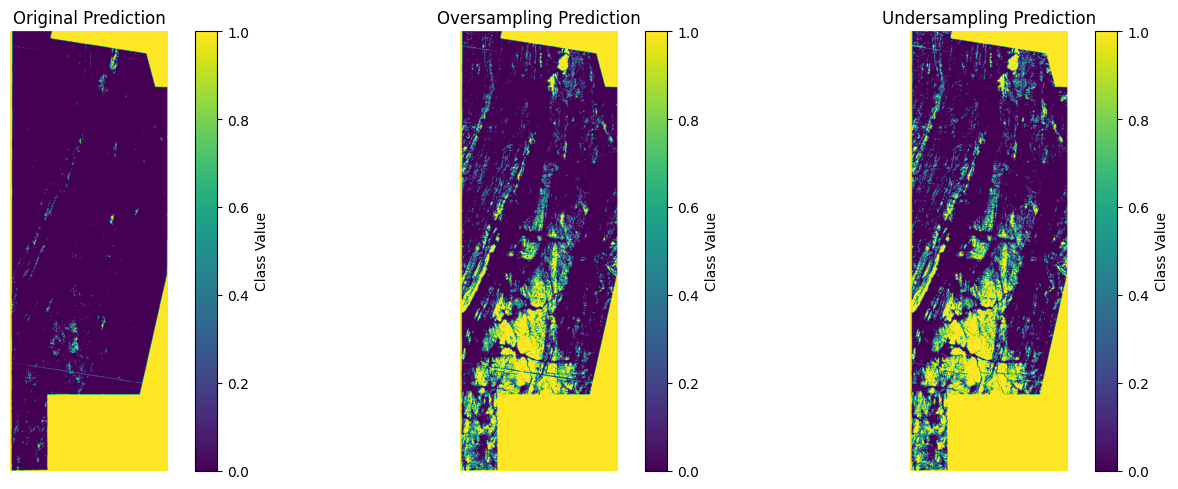

In [ ]:
from rasterio.enums import Resampling
import numpy as np

# Function to resample raster to match the reference raster
def resample_raster(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_meta = ref.meta
        ref_transform = ref.transform
        ref_shape = (ref.height, ref.width)

    with rasterio.open(source_path) as src:
        data = src.read(
            1,
            out_shape=ref_shape,
            resampling=Resampling.bilinear
        )
        transform = src.transform

    return data, ref_meta

# File paths for the input rasters
raster_files = [
    '/content/drive/MyDrive/classification/sample_data/Argillic_PCA1_Proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Iron-oxide_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Phyllic_PCA1_proj.tif',
    '/content/drive/MyDrive/classification/sample_data/Propylitic_PCA1_proj.tif'
]

# Reference raster for resampling (use the first raster as a reference)
reference_raster = raster_files[0]

# Resample rasters
resampled_rasters = []
meta = None

for file in raster_files:
    resampled_data, meta = resample_raster(file, reference_raster)
    resampled_rasters.append(resampled_data)

# Stack the resampled rasters to form a feature array
stacked_data = np.stack(resampled_rasters, axis=-1)

# Flatten the data to create input features for the model
rows, cols, bands = stacked_data.shape
input_features = stacked_data.reshape(-1, bands)

# Match the feature names to those used during training
columns = [
    'Argillic_PCA1_Proj',
    'Iron-oxide_PCA1_proj',
    'Phyllic_PCA1_proj',
    'Propylitic_PCA1_proj'
]
input_features_df = pd.DataFrame(input_features, columns=columns)

# Load the trained models
models = {
    "Original": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_original.pkl',
    "Oversampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_smote.pkl',
    "Undersampling": '/content/drive/MyDrive/classification/Training_test_validation2/Trial2/svm_undersampling.pkl'
}

# Plot results for each model
plt.figure(figsize=(15, 5))

for i, (model_name, model_path) in enumerate(models.items()):
    # Load the model
    model = joblib.load(model_path)


    # Get the expected feature order and reorder input features
    expected_feature_order = model.feature_names_in_
    input_features_df = input_features_df[expected_feature_order]

    # Predict the class values
    predicted_class = model.predict(input_features_df)

    # Reshape predictions back to the raster shape
    predicted_raster = predicted_class.reshape(rows, cols)

    # Save the prediction result as a new raster file
    output_file = f'/content/drive/MyDrive/classification/Training_test_validation2/Trial2/Predicted_map/SVM/predicted_class_SVM_map_{model_name.lower().replace(" ", "_")}_train_test_val.tif'
    meta.update(
        dtype=rasterio.uint8,  # Ensure correct data type
        count=1,              # Number of bands
        nodata=255            # Set nodata to a valid value for uint8
    )

    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(predicted_raster.astype(rasterio.uint8), 1)

    # Plot the prediction raster
    plt.subplot(1, 3, i + 1)
    plt.imshow(predicted_raster, cmap='viridis')
    plt.title(f'{model_name} Prediction')
    plt.axis('off')
    plt.colorbar(label='Class Value')

plt.tight_layout()
plt.show()


#K fold cross validation


In [ ]:
from sklearn.model_selection import cross_val_score

#Apply K-fold cross validation
# 1. On original Data
accuracies_original = cross_val_score(estimator = model_original, X = X_train, y = y_train, cv = 10)
print (accuracies_original)
print(f"The mean accuracy is: {accuracies_original.mean()}")
print(f"The std accuracy is: {accuracies_original.std()}")
print("\n" + "#" * 50 + "\n")
# 2. On Oversampled Data
accuracies_smote = cross_val_score(estimator = model_smote, X = X_train_smote, y = y_train_smote, cv = 10)
print (accuracies_smote)
print(f"The mean accuracy of smote is: {accuracies_smote.mean()}")
print(f"The std accuracy of smote is: {accuracies_smote.std()}")
print("\n" + "#" * 50 + "\n")
# 3. On Undersampled Data
accuracies_under = cross_val_score(estimator = model_under, X = X_train_under, y = y_train_under, cv = 10)
print (accuracies_under)
print(f"The mean accuracy of under is: {accuracies_under.mean()}")
print(f"The std accuracy of under is: {accuracies_under.std()}")

[0.86805556 0.88811189 0.88811189 0.87412587 0.85314685 0.86013986
 0.86013986 0.86013986 0.86713287 0.87412587]
The mean accuracy is: 0.869323038073038
The std accuracy is: 0.011283797366880897

##################################################

[0.76150628 0.74476987 0.79497908 0.78242678 0.78661088 0.80334728
 0.70711297 0.77824268 0.77731092 0.78991597]
The mean accuracy of smote is: 0.7726222706655884
The std accuracy of smote is: 0.026979801134729538

##################################################

[0.79166667 0.625      0.79166667 0.66666667 0.78723404 0.78723404
 0.65957447 0.76595745 0.80851064 0.80851064]
The mean accuracy of under is: 0.7492021276595745
The std accuracy of under is: 0.06639763175930528


# Grid search

In [ ]:
#Applying Grid search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters_original = [
    {'C': [0.1, 1, 10], # , 10, 100,1000
    'gamma': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], #, 0.01, 0.001,0.0001
    'kernel': ['rbf', 'linear', 'poly'], # add 'poly'
    #'degree': [2, 3, 4],  # Only used with 'poly' ,
    #'class_weight': [None, 'balanced']
     }
]
grid_search_original = GridSearchCV(estimator = model_under,
                           param_grid = parameters_original,
                           scoring = 'recall',
                           cv = 10,
                           n_jobs = -1)
grid_search_original.fit(X_train, y_train)
best_accuracy_original = grid_search_original.best_score_
best_parameters_original = grid_search_original.best_params_
best_parameters_original # those results are based on accuracy score{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}, , {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.4, 'kernel': 'rbf'}


{'C': 10, 'gamma': 0.9, 'kernel': 'rbf'}

# For the Oversampling

In [ ]:
grid_search_original = GridSearchCV(estimator = model_smote,
                           param_grid = parameters_original,
                           scoring = 'recall',
                           cv = 10,
                           n_jobs = -1)
grid_search_original.fit(X_train, y_train)
best_accuracy_original = grid_search_original.best_score_
best_parameters_original = grid_search_original.best_params_
best_parameters_original

{'C': 10, 'gamma': 0.9, 'kernel': 'rbf'}